# Calculate Landuse Availabilities

This example shows how `atlite` can deal with landuse restrictions. For the demonstration the effective availability per weather cell is calculated while excluding areas specified by the CORINE CLC raster.  

In [12]:
import atlite
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.plot import show
from atlite.gis import shape_availability, ExclusionContainer

With `geopandas` we retrieve the geographic shapes for 5 countries on the Balkan Peninsula, namely Serbia, Croatia, Macedonia, Bosnia & Herzegovina and Montenegro. 

/var/folders/t6/xl24knbj2f57v2ntl8v7hdfh0000gn/T/ipykernel_25586/2193336252.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


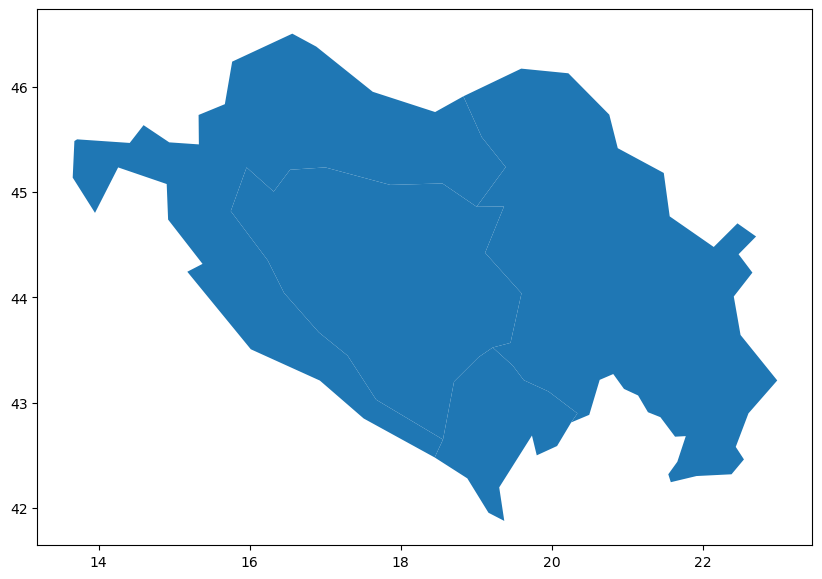

In [13]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries = ["Serbia", "Croatia", "Bosnia and Herz.", "Montenegro"]
shapes = world[world.name.isin(countries)].set_index("name")
shapes.plot(figsize=(10, 7));

We create an `atlite.Cutout` which covers the whole regions and builds the backbone for our analysis. Later, it will enable to retrieve the needed weather data. 

In [14]:
bounds = shapes.cascaded_union.buffer(1).bounds
cutout = atlite.Cutout(
    "balkans", module="era5", bounds=bounds, time=slice("2013-01-01", "2013-01-02")
)

/var/folders/t6/xl24knbj2f57v2ntl8v7hdfh0000gn/T/ipykernel_25586/2540265064.py:1: FutureWarning: The 'cascaded_union' attribute is deprecated, use 'unary_union' instead
  bounds = shapes.cascaded_union.buffer(1).bounds


Let's see how the grid cells and the regional shapes overlap. 

<Axes: >

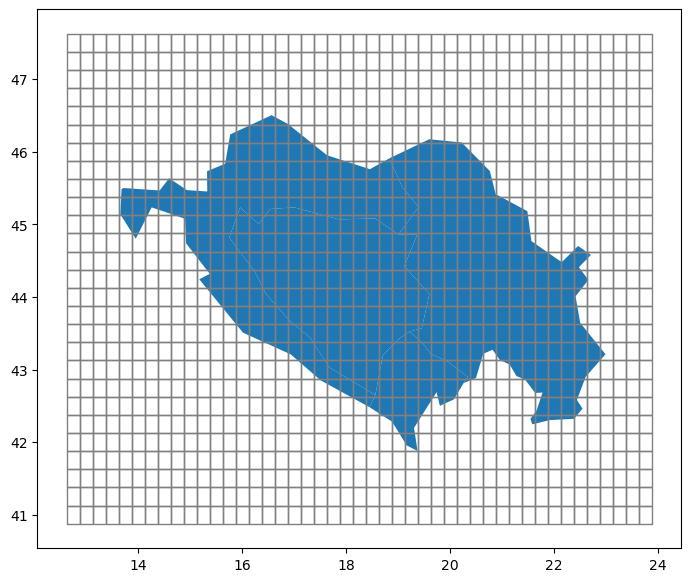

In [15]:
plt.rc("figure", figsize=[10, 7])
fig, ax = plt.subplots()
shapes.plot(ax=ax)
cutout.grid.plot(ax=ax, edgecolor="grey", color="None")

The [CORINE Land Cover (CLC)](https://land.copernicus.eu/pan-european/corine-land-cover) database provides a 100 m x 100 m raster which, for each raster cell, indicates the type of landuse (forest, urban, industrial). In total there are 44 classes. Download the raster (.tif file) from the [download page](https://land.copernicus.eu/pan-european/corine-land-cover/clc2018?tab=download) and store the raster as `corine.tif`. 

For calculating the availability per cutout weather cells, an `ExclusionContainer` must be defined beforehand. It serves as a container for all rasters and geometries we want to exclude (or possibly include). 

In many cases, rasters and geometries have different projections and resolutions. Therefore, the `ExclusionContainer` is initialized by a CRS and a resolution which suits as a basis for all added rasters and geometries. Per default the CRS is 3035 and the resoultion 100, which leads set a raster of 100 meter resolution. All rasters and geometries will be converted to this `(crs, res)` config if they don't match it. 

When adding a raster to the `ExclusionContainer` you can specify which codes (integers) to exclude. 
By setting `invert=True`, you can also restrict the **inclusion** to a set of codes. Further you can buffer around codes (see the docs for detail). Here we are going to exclude the first twenty landuse codes. 

In [16]:
CORINE = "/Users/zhiyu/Desktop/pypsa-mrel-tudv02/atlitewec/examples/corine.tif"
excluder = ExclusionContainer()
excluder.add_raster(CORINE, codes=range(20))

For the demonstration we want to see how the landuse availability behaves within one specific shape, e.g. Croatia. 

Note that, since the excluder is in `crs=3035`, we convert to geometry of Croatia to `excluder.crs` for plotting it...

In [17]:
croatia = shapes.loc[["Croatia"]].geometry.to_crs(excluder.crs)

...and use the `shape_availability` function of `atlite` to calculate a mask for the `ExclusionContainer` excluder. 

In [18]:
masked, transform = excluder.compute_shape_availability(croatia)

The `masked` object is a numpy array. Eligile raster cells have a 1 and excluded cells a 0. Note that this data still lives in the projection of `excluder`. For calculating the eligible share we can use the following routine. 

In [19]:
eligible_share = masked.sum() * excluder.res**2 / croatia.geometry.item().area
print(f"The eligibility share is: {eligible_share:.2%}")

The eligibility share is: 78.99%


For plotting the geometry together with the excluded areas, we can use the function `plot_shape_availability` which uses `rasterio`'s and `geopandas`' plot function in the background. 

<Axes: title={'center': 'Eligible area (green) 78.99%'}>

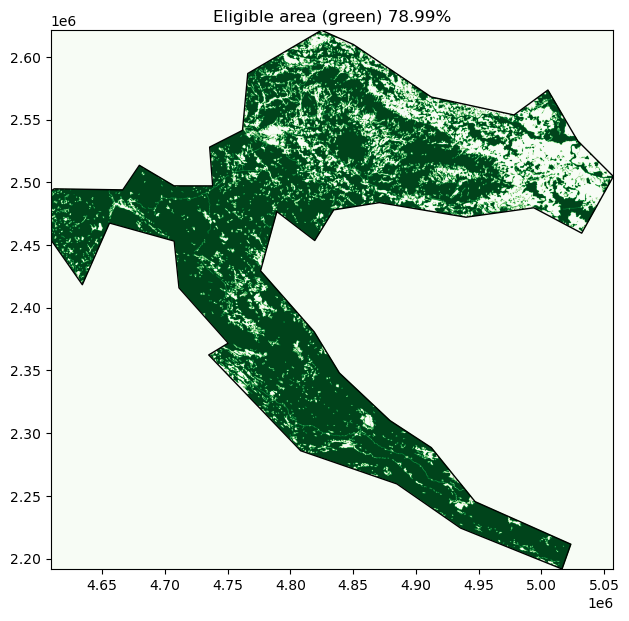

In [20]:
fig, ax = plt.subplots()
excluder.plot_shape_availability(croatia)

How does is look when we add our cutout grid to the plot? How do the weather cells intersect with the available area? 

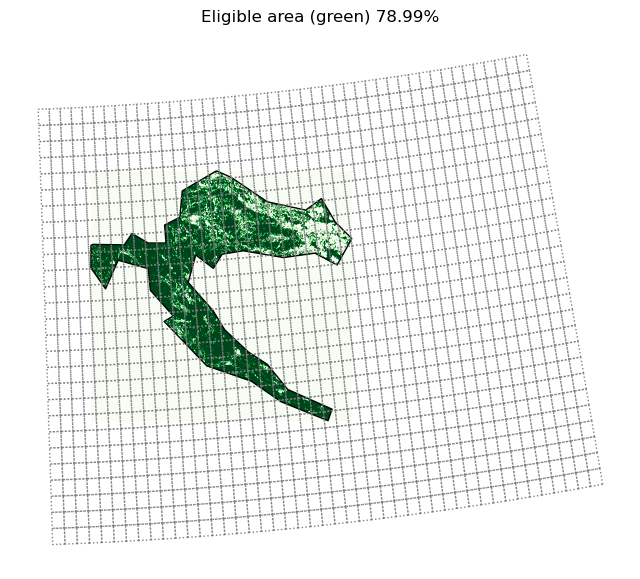

In [21]:
fig, ax = plt.subplots()
excluder.plot_shape_availability(croatia, ax=ax)
cutout.grid.to_crs(excluder.crs).plot(edgecolor="grey", color="None", ax=ax, ls=":")
ax.set_title(f"Eligible area (green) {eligible_share:.2%}")
ax.axis("off");

We see that the weather cells are much larger than the raster cells. `GDAL` provides a fast reprojection function for averaging fine-grained to coarse-grained rasters. `Atlite` automates this calculation for all geometries in `shapes` when calling the `cutout.availabilitymatrix` function. Let's see how this function performs. (Note that the steps before are not necessary for this calculation.)

**INFO**: *For large sets of shapes set nprocesses to a number > 1 for parallelization.*

In [22]:
A = cutout.availabilitymatrix(shapes, excluder)
A

Compute availability matrix: 100%|██████████| 4/4 [00:00<00:00,  5.82 gridcells/s]


<xarray.DataArray (name: 4, y: 27, x: 45)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * name     (name) object 'Croatia' 'Bosnia and Herz.' 'Serbia' 'Montenegro'
  * y        (y) float64 41.0 41.25 41.5 41.75 42.0 ... 46.75 47.0 47.25 47.5
  * x        (x) float64 12.75 13.0 13.25 13.5 13.75 ... 23.0 23.25 23.5 23.75

`A` is an DataArray with 3 dimensions (`shape`, `x`, `y`) and very sparse data. It indicates the relative overlap of weather cell `(x, y)` with geometry `shape` while excluding the area specified by the `excluder`. 

How does the availability look for our example of Croatia?

<Axes: title={'center': 'name = Croatia'}, xlabel='x', ylabel='y'>

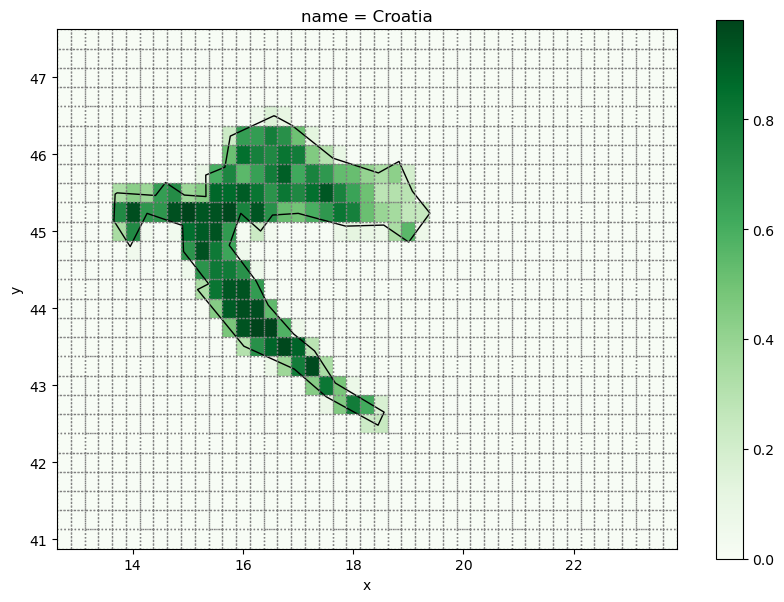

In [23]:
fig, ax = plt.subplots()
A.sel(name="Croatia").plot(cmap="Greens")
shapes.loc[["Croatia"]].plot(ax=ax, edgecolor="k", color="None")
cutout.grid.plot(ax=ax, color="None", edgecolor="grey", ls=":")

Note that now the projection is in `cutout.crs`. In the north-west, where most of the areas were excluded, the availability is lower than 0.5. That means less than the half of these weather cells and their potentials can be exploited. 

And for the other shapes...

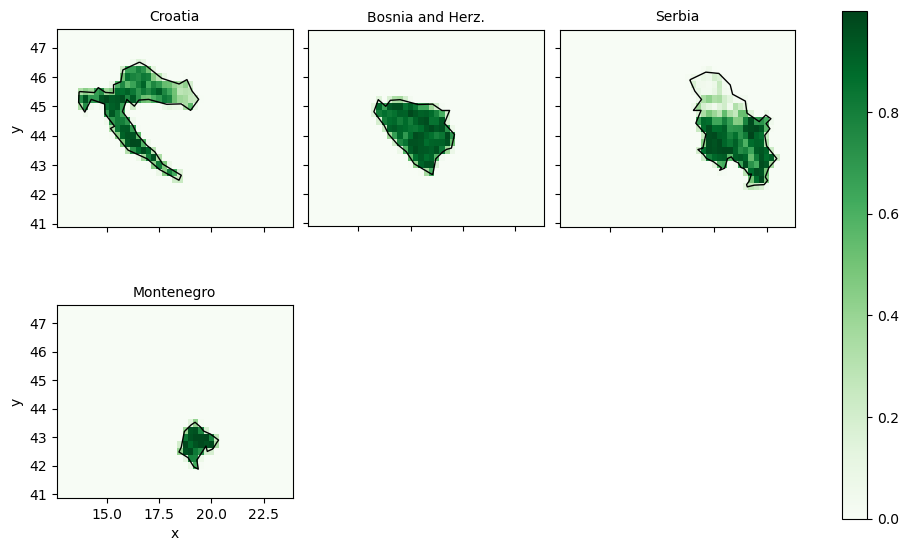

In [24]:
fg = A.plot(row="name", col_wrap=3, cmap="Greens")
fg.set_titles("{value}")
for i, c in enumerate(shapes.index):
    shapes.loc[[c]].plot(ax=fg.axs.flatten()[i], edgecolor="k", color="None")

The availibility matrix `A` can now be used as a layoutmatrix in the conversion functions of `atlite`, i.e. `cutout.pv`, `cutout.wind`. The normal approach would be to weigh the availabilities with the area per grid cell and the capacity per area.

In [43]:
cap_per_sqkm = 1.7
area = cutout.grid.set_index(["y", "x"]).to_crs(3035).area / 1e6
area = xr.DataArray(area, dims=("spatial"))

capacity_matrix = A.stack(spatial=["y", "x"]) * area * cap_per_sqkm

In [48]:
capacity_matrix

<xarray.DataArray (name: 4, spatial: 1215)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * name     (name) object 'Croatia' 'Bosnia and Herz.' 'Serbia' 'Montenegro'
  * spatial  (spatial) object MultiIndex
  * y        (spatial) float64 41.0 41.0 41.0 41.0 41.0 ... 47.5 47.5 47.5 47.5
  * x        (spatial) float64 12.75 13.0 13.25 13.5 ... 23.0 23.25 23.5 23.75

After the cutout preparation, we can calculate the static and dynamic capacity factors of each region. 

In [46]:
cutout.prepare()
pv, capacity = cutout.pv(
    matrix=capacity_matrix,
    panel=atlite.solarpanels.CdTe,
    orientation="latitude_optimal",
    index=shapes.index,
    return_capacity=True,
)

da dimensions after stacking: ('time', 'spatial')


Finally let's see how the total power potential per region look. 

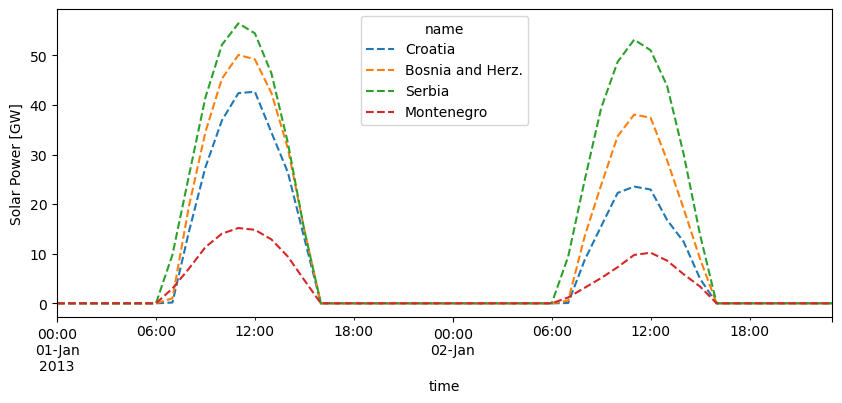

In [27]:
pv.to_pandas().div(1e3).plot(ylabel="Solar Power [GW]", ls="--", figsize=(10, 4));